# Locating longitudinal-transverse correlation in transverse phase space 

The goal of this notebook is to identify the "width" of the measured longitudinal-transverse correlation in the phase space distribution of the BTF bunch at the first emittance station. We will look at the energy distribution of particles within a boundary in 4D transverse phase space.

In [1]:
import sys
import os
from os.path import join
import importlib
import numpy as np
import pandas as pd
import h5py
from tqdm.notebook import tqdm
from tqdm.notebook import trange
import seaborn as sns
from matplotlib import pyplot as plt
from ipywidgets import interactive
from ipywidgets import widgets
import proplot as pplt

sys.path.append('../..')
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'

## Load data 

In [3]:
folder = '_saved/2021-12-03-VS06'

In [4]:
info = utils.load_pickle(join(folder, 'info.pkl'))
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2021-12-03/',
 'filename': 'merged2-211203151919-211203192701-scan-xxpy-image-ypdE',
 'variables': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ04',
   'center': 14.5,
   'distance': 22.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT06',
   'center': 13.5,
   'distance': 13.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT04',
   'center': 13.0,
   'distance': 17.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1.  , 0.  , 0.  ],
        [0.  , 1.  , 0.65],
        [0.  , 0.  , 1.  ]]),
 'ndim': 3,
 'cam': 'cam06',
 'cam_zoom': 1.0,
 'cam_pix2mm_y': 0.0659,
 'cam_pix2mm_x': 0.0659,
 'cam_shape': (258, 346),
 'signal_thresh': 0.0017,
 'image_crop_edges': {'x1': 45, 'x2': 300, 'y1': 20, 'y2': 237},
 'image_offset': 0.0,
 'noise_icenter': 17714,
 'image_thresh': 1450.

In [5]:
filename = info['filename']
coords = utils.load_stacked_arrays(join(folder, f'coords_{filename}.npz'))
shape = tuple([len(c) for c in coords])
print('shape:', shape)

shape: (36, 52, 36, 80, 93)


In [6]:
f = np.memmap(join(folder, f'f_{filename}.mmp'), shape=shape, dtype='float', mode='r')

In [7]:
f_max = np.max(f)
f_min = np.min(f)
if f_min < 0.0:
    print(f'min(f) = {f_min}')
    print('Clipping to zero.')
    f = np.clip(f, 0.0, None)

min(f) = -1.139861541937893e-12
Clipping to zero.


In [8]:
dims = ["x", "xp", "y", "yp", "w"]
units = ["mm", "mrad", "mm", "mrad", "MeV"]
dims_units = [f'{d} [{u}]' for d, u in zip(dims, units)]
prof_kws = dict(lw=0.5, alpha=0.7, color='white', scale=0.12)

Crop the 5D array.

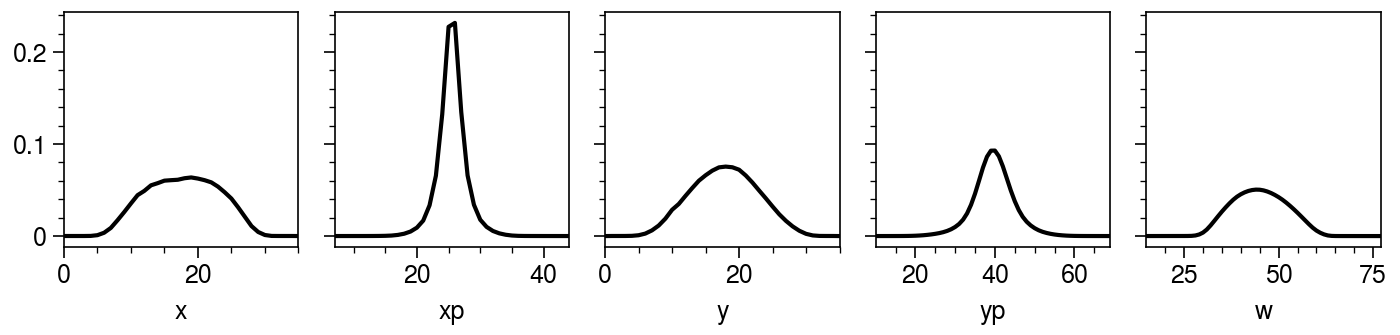

In [9]:
crop = (
    (0, f.shape[0]),
    (7, f.shape[1] - 7),
    (0, f.shape[2]),
    (10, f.shape[3] - 10),
    (15, f.shape[4] - 15),
)

fig, axes = pplt.subplots(ncols=5, figwidth=7, spanx=False, figheight=None)
for i, ax in enumerate(axes):
    p = utils.project(f, i)
    p = p / np.sum(p)
    ax.plot(p, color='black')
    ax.format(xlabel=dims[i], xlim=(crop[i][0], crop[i][1] - 1))
# axes.format(yscale='log')
plt.show()

In [10]:
ind = tuple([slice(c[0], c[1]) for c in crop])
f = f[ind]
coords = [c[ind[i]] for i, c in enumerate(coords)]

## View correlation in rectangular slices in 4D phase space 

In [12]:
f_max = np.max(f)
f_min = np.min(f)

First view the 2D projections at integer slices. (Set `frac_thresh` to -3.0.)

In [13]:
mplt.interactive_proj2d(f / f_max, coords=coords, dims=dims, units=units)

interactive(children=(Dropdown(description='handle_log', options=('floor', 'mask'), value='floor'), Dropdown(d…

And at range slices.

In [14]:
mplt.interactive_proj2d(f / f_max, coords=coords, dims=dims, units=units,
                        slice_type='range')

interactive(children=(Dropdown(description='handle_log', options=('floor', 'mask'), value='floor'), Dropdown(d…

In [15]:
frac_thresh = 10.0**-3.0

And all 2D projections.

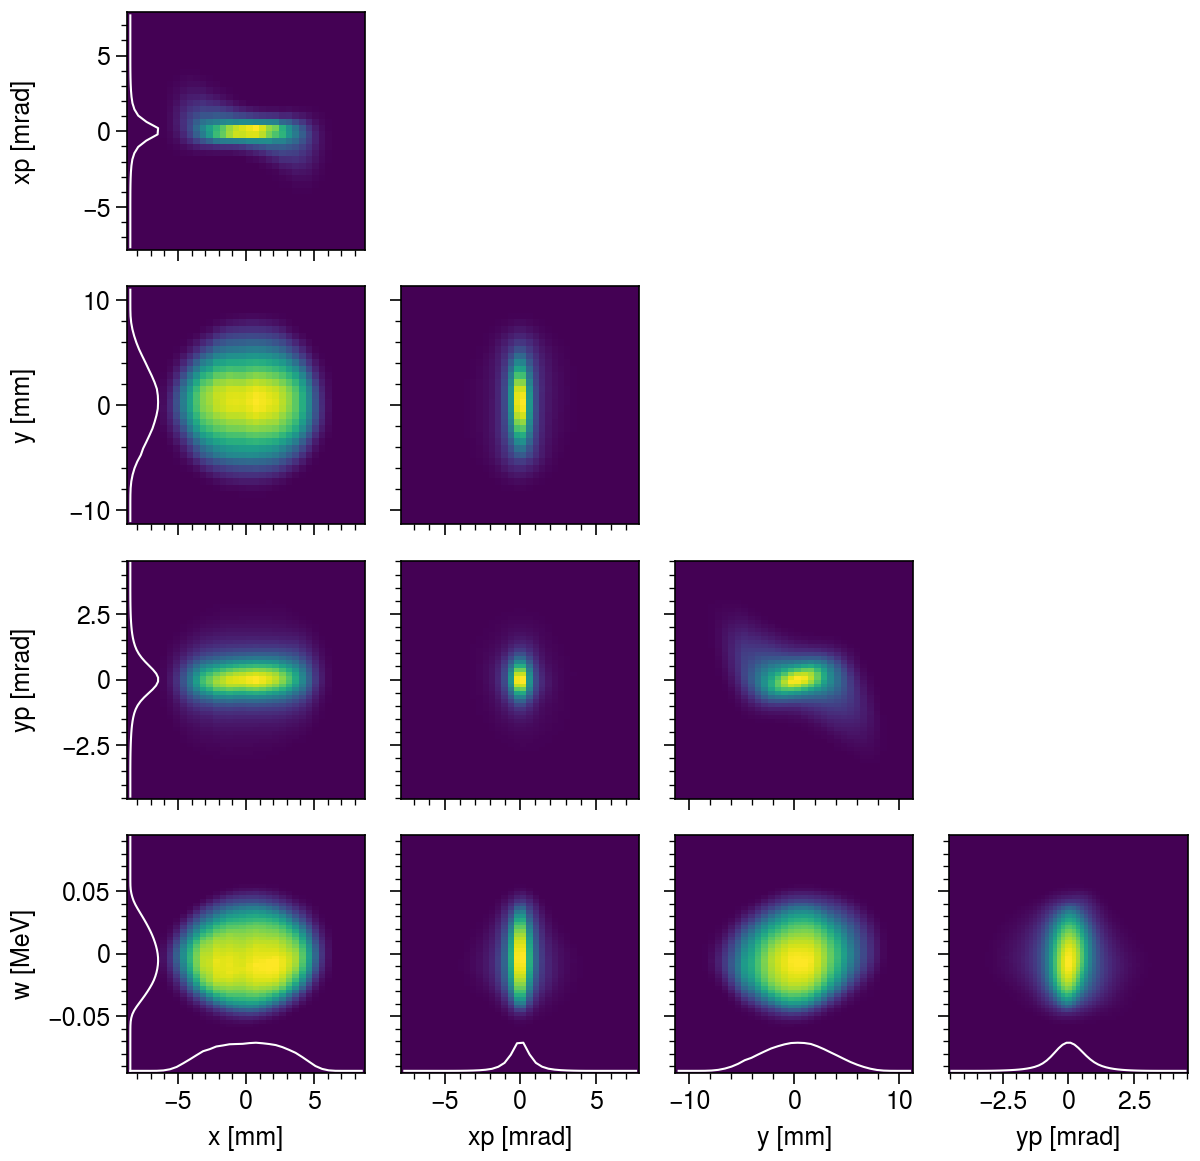

In [16]:
axes = mplt.corner(
    f,
    coords=coords,
    diag_kind='None',
    labels=dims_units,
    norm=None,
    frac_thresh=frac_thresh,
    prof='edges',
    prof_kws=dict(),
)

View the 1D energy projections.

In [17]:
mplt.interactive_proj1d(f, coords=coords, dims=dims, units=units, default_ind=4,
                        slice_type='int')

interactive(children=(Dropdown(description='dim', index=4, options=('x', 'xp', 'y', 'yp', 'w'), value='w'), Ch…

In [18]:
mplt.interactive_proj1d(f, coords=coords, dims=dims, units=units, default_ind=4,
                        slice_type='range')

interactive(children=(Dropdown(description='dim', index=4, options=('x', 'xp', 'y', 'yp', 'w'), value='w'), Ch…

## Energy projection within 4D transverse contours

An example of contours in 2D phase space.

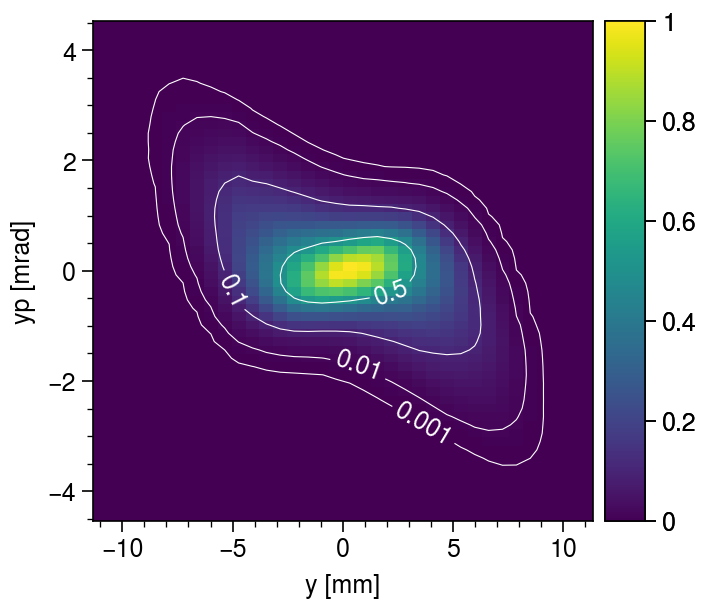

In [140]:
f2d = project(f, (2, 3))
f2d = f2d / np.max(f2d)

fig, ax = pplt.subplots()
mplt.plot_image(
    f2d, x=coords[2], y=coords[3], ax=ax,
    contour=True, 
    contour_kws=dict(
        labels=True, 
        color='white',
        lw=0.4,
        alpha=1,
        levels=(0.001, 0.01, 0.1, 0.5, 1.0),
    ),
    colorbar=True,
)
ax.format(xlabel="y [mm]", ylabel="yp [mrad]")
# plt.savefig('contour_yyp.png')
plt.show()

Project the distribution onto transverse phase space.

In [19]:
ftr = project(f, axis=(0, 1, 2, 3))
ftr = ftr / np.max(ftr)

View the distribution of pixel values in the array.

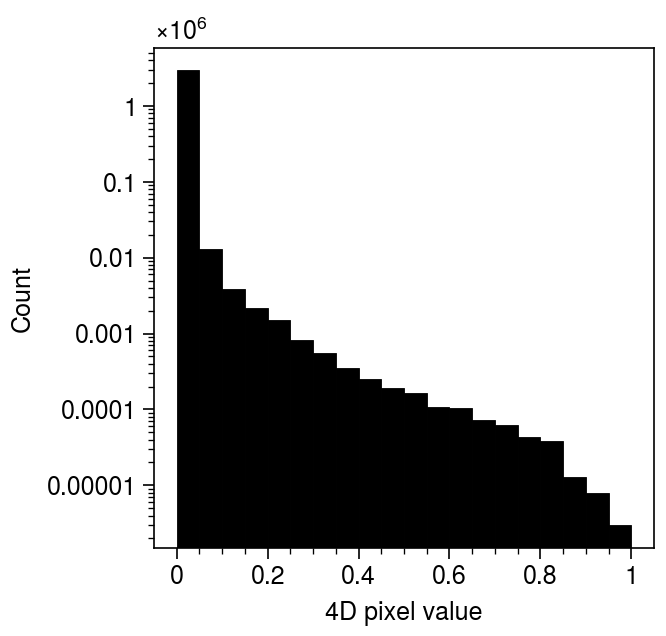

In [20]:
fig, ax = pplt.subplots()
ax.hist(ftr.ravel(), bins=20, color='black')
ax.format(yscale='log', ylabel='Count', xlabel='4D pixel value')
plt.show()

Plot the energy distribution of a shrinking 4D phase space volume. The volume is defined by a contour in 4D phase space.

In [32]:
def energy_proj(f, ftr=None, level=0.5, normalize=True):
    if ftr is None:
        ftr = np.sum(f, axis=-1)
    pw = np.sum(f[np.where(ftr > level)], axis=0)
    if normalize:
        pw = pw / np.sum(pw)
    return pw

In [34]:
def update(level):
    pw = energy_proj(f, ftr, level, normalize=True)
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.format(xlabel=dims_units[4])
    ax.bar(coords[4], pw, color='black')
    plt.show()
    
interactive(update, level=(0.0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='level', max=0.99, step=0.01), Output()), _dom_class…

In [87]:
n = 20
levels = np.linspace(0.99, 0.01, n)
pws = np.array([energy_proj(f, ftr, level) for level in levels]) 
pws = pws / np.max(pws)

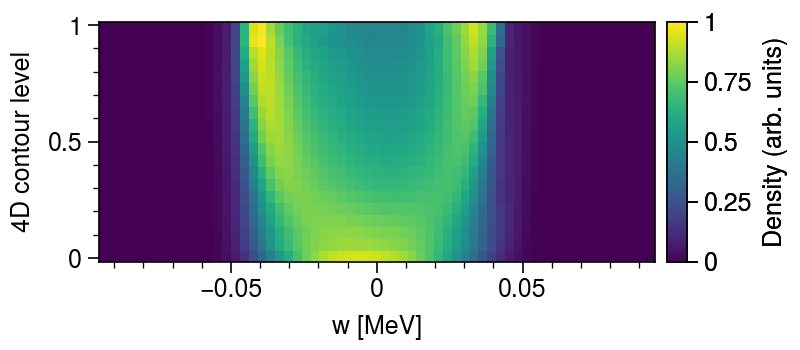

In [110]:
fig, ax = pplt.subplots(figsize=(4, 1.75))
ax.pcolormesh(coords[4], levels[::-1], pws[::-1],
              colorbar=True, colorbar_kw=dict(label='Density (arb. units)', width=0.1))
ax.format(xlabel='w [MeV]', ylabel='4D contour level')
plt.show()

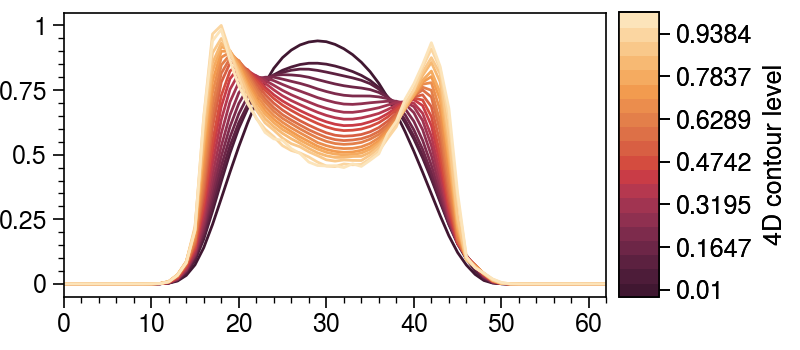

In [119]:
cmap = pplt.Colormap('fire_r', left=0.0, right=0.9)
# cmap = pplt.Colormap('crest', left=0.0, right=1.0)

fig, ax = pplt.subplots(figsize=(4, 1.75))
ax.plot(pws[::-1].T, cycle=cmap, lw=1, colorbar=True, 
        colorbar_kw=dict(values=levels[::-1], label='4D contour level'))
plt.show()

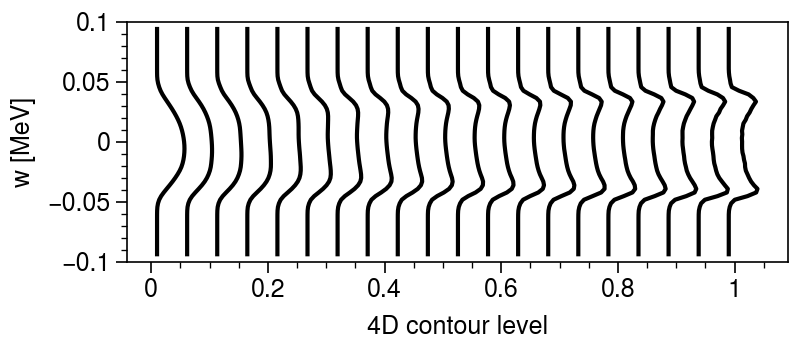

In [137]:
fig, ax = pplt.subplots(figsize=(4.0, 1.75))
for i, (color, pw) in enumerate(zip(pplt.get_colors('flare', len(pws)), pws)):
    x = coords[4]
    y = levels[i] + 0.05 * pw 
    ax.plotx(x, y, 
             # color=color
            color='black',
           )
ax.format(ylim=(-0.1, 0.1))
ax.format(ylabel='w [MeV]', xlabel='4D contour level')
# plt.savefig('4Dcontour_dE2.png')

Plot 2D contours for visualization purposes.

### More plots

I want to see what the distribution looks like as I slice it. Find the mask in the transverse phase space, then copy the mask along the last axis of the array to get a 5D mask.

In [ ]:
def update(level):
    # print('calculating...')
    condition = ftr < level
    condition = utils.copy_into_new_dim(condition, f.shape[4])
    _f = np.ma.masked_where(condition, f)
    p = np.sum(_f, (0, 1, 2, 3))
    p = p / np.sum(p)
    # print('done calculating')
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.format(xlabel=dims_units[4])
    ax.bar(coords[4], p, color='black')
    plt.show()
    
interactive(update, level=(0.0, 0.99, 0.01))

Make sure you get the same thing.

In [ ]:
n = 20
levels = np.linspace(0.99, 0.01, n)
pws = np.zeros((n, f.shape[4]))
for i, level in enumerate(tqdm(levels)):
    mask = ftr < level
    mask = utils.copy_into_new_dim(mask, f.shape[4])
    _f = np.ma.masked_array(f, mask=mask)
    pws[i] = project(_f, axis=4)
    pws[i] = pws[i] / np.sum(pws[i])

In [ ]:
fig, ax = pplt.subplots(figsize=(4.5, 1.75))
for i, (color, pw) in enumerate(zip(pplt.get_colors('flare', len(pws)), pws)):
    x = coords[4]
    y = pw + levels[i]
    ax.plotx(x, y, color='black')
ax.format(ylim=(-0.1, 0.1))
ax.format(ylabel='w [MeV]', xlabel='4D contour level')
# plt.savefig('4Dcontour_dE2.png')